# 신용카드사기탐지 모델

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from sklearnex import patch_sklearn
patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [62]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

In [63]:
data = pd.read_csv('./data/fraud.csv')
data.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011,-82.048,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.888,-118.210,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159,-118.186,0


In [64]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

In [65]:
data.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000,1852394.000
mean,417386038393710400.000,70.064,48813.258,38.539,-90.228,88643.675,1358674218.834,38.539,-90.228,0.005
std,1309115265318734848.000,159.254,26881.846,5.071,13.748,301487.618,18195081.388,5.106,13.760,0.072
min,60416207185.000,1.000,1257.000,20.027,-165.672,23.000,1325376018.000,19.027,-166.672,0.000
25%,180042946491150.000,9.640,26237.000,34.669,-96.798,741.000,1343016823.750,34.740,-96.899,0.000
50%,3521417320836166.000,47.450,48174.000,39.354,-87.477,2443.000,1357089331.000,39.369,-87.441,0.000
75%,4642255475285942.000,83.100,72042.000,41.940,-80.158,20328.000,1374581485.250,41.956,-80.245,0.000
max,4992346398065154048.000,28948.900,99921.000,66.693,-67.950,2906700.000,1388534374.000,67.510,-66.951,1.000


In [66]:
# 의미있는 컬럼만 선택
data[['amt', 'city_pop']].describe()

,amt,city_pop
count,1852394.000,1852394.000
mean,70.064,88643.675
std,159.254,301487.618
min,1.000,23.000
25%,9.640,741.000
50%,47.450,2443.000
75%,83.100,20328.000
max,28948.900,2906700.000


In [67]:
# 결측치 없음을 확인
data.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [68]:
# 문자형 / 숫자형으로 구분
data_obj = data.select_dtypes(include='object')
data_num = data.select_dtypes(exclude='object')

In [69]:
data_obj.columns

Index(['trans_date_trans_time', 'merchant', 'category', 'first', 'last',
       'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num'],
      dtype='object')

In [70]:
for col in data_obj:
    print('='*30, col, '='*30)
    print(f'{col}의 unique의 수 = {data_obj[col].nunique()}', end='\n\n')
    print(data_obj[col].value_counts(), end='\n\n')
    
    print(data[[col, 'is_fraud']].groupby(col).mean().sort_values(by='is_fraud', ascending=False), end='\n\n')

============================== trans_date_trans_time ==============================
trans_date_trans_time의 unique의 수 = 1819551

trans_date_trans_time
2019-04-22 16:02:01    4
2020-06-01 01:37:47    4
2020-06-02 12:47:07    4
2020-10-05 19:37:49    4
2020-12-13 17:53:47    4
                      ..
2019-01-01 00:41:45    1
2019-01-01 00:42:26    1
2019-01-01 00:43:38    1
2019-01-01 00:44:20    1
2020-12-31 23:50:17    1
Name: count, Length: 1819551, dtype: int64

                       is_fraud
trans_date_trans_time          
2019-09-11 22:58:11       1.000
2019-12-22 01:09:30       1.000
2019-02-12 23:49:17       1.000
2019-09-23 06:33:47       1.000
2019-05-03 04:38:52       1.000
...                         ...
2019-01-01 00:41:45       0.000
2019-01-01 00:42:26       0.000
2019-01-01 00:43:38       0.000
2019-01-01 00:44:20       0.000
2020-12-31 23:50:17       0.000

[1819551 rows x 1 columns]

============================== merchant ==============================
merchant의 uniqu

                          is_fraud
job                               
Accountant, chartered        1.000
Warehouse manager            1.000
Careers adviser              1.000
Solicitor                    1.000
Ship broker                  1.000
...                            ...
Health physicist             0.001
Contractor                   0.000
Engineer, communications     0.000
Engineer, drilling           0.000
Stage manager                0.000

[497 rows x 1 columns]

============================== dob ==============================
dob의 unique의 수 = 984

dob
1977-03-23    8044
1988-09-15    6574
1981-08-29    6571
1955-05-06    5121
1960-01-13    4395
              ... 
1962-03-14       7
1944-06-17       7
1970-06-25       7
1932-05-09       7
1998-08-02       6
Name: count, Length: 984, dtype: int64

            is_fraud
dob                 
2001-07-17     1.000
2002-03-17     1.000
1925-08-29     1.000
1927-02-03     1.000
1944-05-30     1.000
...              ...
1949-10-04 

In [74]:
# 하나의 카드로 이상거래인 경우만 나오게 된다 -> 범죄에 사용된 경우일 수 있음
print('결제 확인된 건수: ',len(data[data['state'] == 'DE']))
data[data['state'] == 'DE']['cc_num'].unique()

결제 확인된 건수:  9


array([6011826317034777])

obj에서 사용할 컬럼 : 'trans_date_trans_time', 'merchant', 'category', 'gender', 'street', 'city', 'state', 'job', 'dob'

In [19]:
data_num.columns

Index(['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [25]:
from ydata_profiling import ProfileReport

C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
profile = ProfileReport(data, title="Profiling Report")

In [27]:
profile.to_file("is_froad_eda.html")

Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.18it/s]


# EDA
- cc_num의 유니크값 : 999 -> 999명의 거래데이터
- 집 위치와 상점 위치가 서로 연관이 있다

False
2


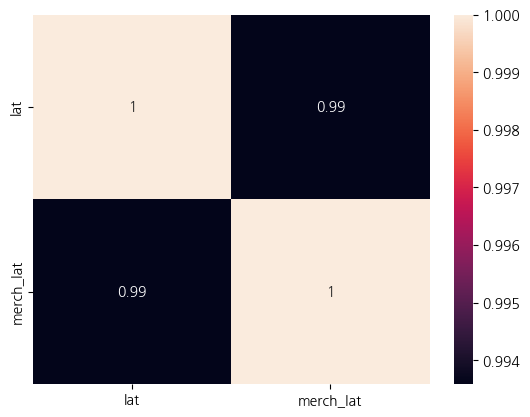

In [79]:
# 고객 거주 지역의 위도와 상점의 위도의 연관성 확인
import matplotlib.pyplot as plt


print((data['lat'] == data['merch_lat']).all())
print((data['lat'] == data['merch_lat']).sum())

corr = data[['lat', 'merch_lat']].corr()
sns.heatmap(corr, annot=True)
plt.show()

False
1


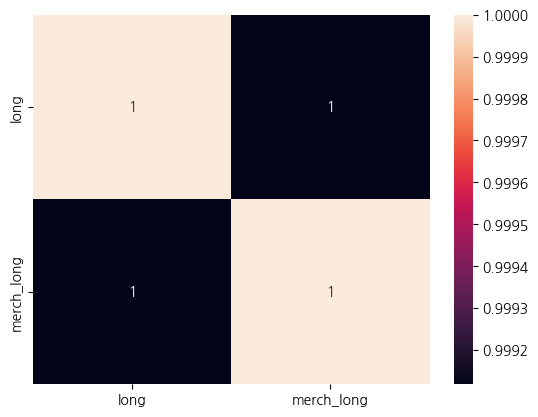

In [80]:
# 고객 거주 지역의 경도와 상점의 경도의 연관성 확인
print((data['long'] == data['merch_long']).all())
print((data['long'] == data['merch_long']).sum())

corr = data[['long', 'merch_long']].corr()
sns.heatmap(corr, annot=True)
plt.show()

In [81]:
# 사용자별로 소비패턴을 분석하면 카드 이상 거래 포착에 용이할 것 
data['cc_num'].nunique()

999

### is_fraud의 비율

In [82]:
# 굉장히 낮은 비율의 이상거래가 존재한다
# 전체 데이터셋의 0.52 % 차지 
data['is_fraud'].mean() * 100

np.float64(0.5210014716091717)

## 카드별(고객별) 거래 금액에서의 이상치를 찾음
- is_fraud와의 관계 확인

-----
### 이상값 탐지
- 1) IQR 활용
- 2) Z-Score 활용

In [83]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [84]:
amt_desc = data.groupby(['cc_num'])['amt'].describe()
amt_desc

,count,mean,std,min,25%,50%,75%,max
cc_num,,,,,,,,
60416207185,2196.000,59.258,142.870,1.020,7.560,36.540,72.802,3437.460
60422928733,2200.000,65.483,92.043,1.010,9.075,51.405,87.085,1290.370
60423098130,738.000,96.376,1000.694,1.010,8.780,35.425,75.463,27119.770
60427851591,743.000,107.488,131.015,8.860,59.140,76.670,99.110,1164.360
60487002085,735.000,64.097,153.208,1.020,8.095,35.670,70.855,2758.460
...,...,...,...,...,...,...,...,...
4958589671582726883,2191.000,67.206,137.504,1.000,8.830,50.130,84.455,4292.860
4973530368125489546,1467.000,75.789,258.847,1.010,9.435,52.660,88.340,8749.440
4980323467523543940,736.000,70.709,119.903,1.010,8.465,42.515,83.458,1327.430


In [85]:
amt_desc.columns

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [86]:
amt_desc['iqr_max'] = amt_desc['75%'] + (1.5 * (amt_desc['75%'] - amt_desc['25%']))
amt_desc

,count,mean,std,min,25%,50%,75%,max,iqr_max
cc_num,,,,,,,,,
60416207185,2196.000,59.258,142.870,1.020,7.560,36.540,72.802,3437.460,170.666
60422928733,2200.000,65.483,92.043,1.010,9.075,51.405,87.085,1290.370,204.100
60423098130,738.000,96.376,1000.694,1.010,8.780,35.425,75.463,27119.770,175.486
60427851591,743.000,107.488,131.015,8.860,59.140,76.670,99.110,1164.360,159.065
60487002085,735.000,64.097,153.208,1.020,8.095,35.670,70.855,2758.460,164.995
...,...,...,...,...,...,...,...,...,...
4958589671582726883,2191.000,67.206,137.504,1.000,8.830,50.130,84.455,4292.860,197.892
4973530368125489546,1467.000,75.789,258.847,1.010,9.435,52.660,88.340,8749.440,206.697
4980323467523543940,736.000,70.709,119.903,1.010,8.465,42.515,83.458,1327.430,195.946


In [87]:
amt_desc = amt_desc.reset_index()
amt_desc

,cc_num,count,mean,std,min,25%,50%,75%,max,iqr_max
0,60416207185,2196.000,59.258,142.870,1.020,7.560,36.540,72.802,3437.460,170.666
1,60422928733,2200.000,65.483,92.043,1.010,9.075,51.405,87.085,1290.370,204.100
2,60423098130,738.000,96.376,1000.694,1.010,8.780,35.425,75.463,27119.770,175.486
3,60427851591,743.000,107.488,131.015,8.860,59.140,76.670,99.110,1164.360,159.065
4,60487002085,735.000,64.097,153.208,1.020,8.095,35.670,70.855,2758.460,164.995
...,...,...,...,...,...,...,...,...,...,...
994,4958589671582726883,2191.000,67.206,137.504,1.000,8.830,50.130,84.455,4292.860,197.892
995,4973530368125489546,1467.000,75.789,258.847,1.010,9.435,52.660,88.340,8749.440,206.697
996,4980323467523543940,736.000,70.709,119.903,1.010,8.465,42.515,83.458,1327.430,195.946
997,4989847570577635369,1471.000,93.009,128.397,1.030,19.940,57.170,111.945,1223.850,249.952


In [88]:
amt_desc.columns

Index(['cc_num', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',
       'iqr_max'],
      dtype='object')

In [91]:
amt_desc.columns = ['cc_num', 'count', 'amt_mean', 'amt_std', 'min', '25%', '50%', '75%', 'max', 'amt_iqr_max']
amt_desc

,cc_num,count,amt_mean,amt_std,min,25%,50%,75%,max,amt_iqr_max
0,60416207185,2196.000,59.258,142.870,1.020,7.560,36.540,72.802,3437.460,170.666
1,60422928733,2200.000,65.483,92.043,1.010,9.075,51.405,87.085,1290.370,204.100
2,60423098130,738.000,96.376,1000.694,1.010,8.780,35.425,75.463,27119.770,175.486
3,60427851591,743.000,107.488,131.015,8.860,59.140,76.670,99.110,1164.360,159.065
4,60487002085,735.000,64.097,153.208,1.020,8.095,35.670,70.855,2758.460,164.995
...,...,...,...,...,...,...,...,...,...,...
994,4958589671582726883,2191.000,67.206,137.504,1.000,8.830,50.130,84.455,4292.860,197.892
995,4973530368125489546,1467.000,75.789,258.847,1.010,9.435,52.660,88.340,8749.440,206.697
996,4980323467523543940,736.000,70.709,119.903,1.010,8.465,42.515,83.458,1327.430,195.946
997,4989847570577635369,1471.000,93.009,128.397,1.030,19.940,57.170,111.945,1223.850,249.952


In [92]:
data = pd.merge(data, amt_desc[['cc_num', 'amt_mean', 'amt_std', 'amt_iqr_max']], how='left', on='cc_num')
data

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011,-82.048,0,89.409,127.530,256.620
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.888,-118.210,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159,-118.186,0,56.078,159.202,158.060
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.181,-112.262,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.151,-112.154,0,69.924,116.689,210.800
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.231,-112.114,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034,-112.561,0,80.090,280.078,193.098
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.675,-78.632,0,95.341,94.323,149.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.770,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.493,-91.891,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.947,-91.333,0,62.348,110.821,182.535
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.840,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.039,-95.440,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661,-96.187,0,50.452,168.361,136.045
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.880,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.197,-118.902,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658,-119.715,0,88.704,119.949,261.548
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.990,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.626,-116.449,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.471,-117.081,0,60.998,89.526,186.940


In [93]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_mean', 'amt_std', 'amt_iqr_max'],
      dtype='object')

In [94]:
data = data.drop([ 'first', 'last', 'street', 'city', 'state', 'zip', 'trans_num', 'unix_time'], axis=1)
data

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,F,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,36.011,-82.048,0,89.409,127.530,256.620
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,F,48.888,-118.210,149,Special educational needs teacher,1978-06-21,49.159,-118.186,0,56.078,159.202,158.060
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,M,42.181,-112.262,4154,Nature conservation officer,1962-01-19,43.151,-112.154,0,69.924,116.689,210.800
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,M,46.231,-112.114,1939,Patent attorney,1967-01-12,47.034,-112.561,0,80.090,280.078,193.098
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,M,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,38.675,-78.632,0,95.341,94.323,149.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.770,M,40.493,-91.891,519,Town planner,1966-02-13,39.947,-91.333,0,62.348,110.821,182.535
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.840,M,29.039,-95.440,28739,Futures trader,1999-12-27,29.661,-96.187,0,50.452,168.361,136.045
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.880,F,46.197,-118.902,3684,Musician,1981-11-29,46.658,-119.715,0,88.704,119.949,261.548
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.990,M,44.626,-116.449,129,Cartographer,1965-12-15,44.471,-117.081,0,60.998,89.526,186.940


In [95]:
# 이상치인 값이 전체 데이터셋의 8.3 % 정도 나온다 -> 높다고 할 수는 없음
data.loc[data['amt'] > data['amt_iqr_max'], 'is_fraud'].mean() * 100

np.float64(8.316776198481838)

# 사용금액의 z-score를 구한 후 사기 비율 계산
- z-score = (값 - 평균) / 표준편차
- 이상값 판단 기준 : -3 미만이거나 +3 초과하는 경우 이상치로 판단

In [97]:
data['amt_zscore'] = (data['amt'] - data['amt_mean']) / data['amt_std']

In [99]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max,amt_zscore
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,F,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,36.011,-82.048,0,89.409,127.530,256.620,-0.662
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,F,48.888,-118.210,149,Special educational needs teacher,1978-06-21,49.159,-118.186,0,56.078,159.202,158.060,0.321
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,M,42.181,-112.262,4154,Nature conservation officer,1962-01-19,43.151,-112.154,0,69.924,116.689,210.800,1.287
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,M,46.231,-112.114,1939,Patent attorney,1967-01-12,47.034,-112.561,0,80.090,280.078,193.098,-0.125
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,M,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,38.675,-78.632,0,95.341,94.323,149.974,-0.566


In [100]:
# 이상치에 해당하는 값들의 이상거래 여부 value_counts 확인
data[(data['amt_zscore'] > 3) | (data['amt_zscore'] < -3)]['is_fraud'].value_counts()

is_fraud
0    21725
1     4092
Name: count, dtype: int64

In [101]:
# 전체데이터셋의 15.85 % 정도 차지 -> 큰 범위를 차지한다고 볼 수는 없지만
# IQR로 확인한 경우보다는 이상치의 비율이 확연하게 늘어남
data[(data['amt_zscore'] > 3) | (data['amt_zscore'] < -3)]['is_fraud'].mean() * 100

np.float64(15.850021303792076)

# 사용자가 어디에 주로 지출하는가?
- 소비 패턴 파악
- 기존의 패턴이 아닌 다른 패턴이 생기는 경우를 이상거래로 판단할 수 있음
    - 식품에 지출이 많은 사람이 레저용품에 지출이 갑자기 많이 한다? -> 이상거래 가능성 존재
    - 평소 지출하는 카테고리 혹은 가게가 아닌 경우 -> 이상거래 가능성 존재
- 카드 번호별, 카테고리별 지출 평균, 표준편차

In [102]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_mean', 'amt_std', 'amt_iqr_max',
       'amt_zscore'],
      dtype='object')

In [103]:
cat_amt = data.groupby(['cc_num', 'category'])['amt'].agg(['mean', 'std']).reset_index()
cat_amt.head()

,cc_num,category,mean,std
0,60416207185,entertainment,51.839,65.486
1,60416207185,food_dining,26.737,46.383
2,60416207185,gas_transport,59.779,15.758
3,60416207185,grocery_net,52.153,17.695
4,60416207185,grocery_pos,101.558,21.894


In [104]:
cat_amt.columns = ['cc_num', 'category', 'cat_amt_mean', 'cat_amt_std']

In [106]:
data = pd.merge(data, cat_amt, how='left', on=['cc_num', 'category'])

In [107]:
data['cat_amt_zscore'] = (data['amt'] - data['cat_amt_mean']) / data['cat_amt_std']

In [108]:
# 전체데이터셋의 19.30 % 정도 차지 -> 의미있는 비율이 될 수 있음
data[(data['cat_amt_zscore'] < -3) | (data['cat_amt_zscore'] > 3)]['is_fraud'].mean() * 100

np.float64(19.290895447723862)

# 집의 위치와 가게의 위치 상관관계 높음
- https://geopy.readthedocs.io/en/stable/#module-geopy.distance
- 집과 가게의 거리를 위도 경도 데이터를 이용해 계산하여 평균 거리를 초과하는 곳에서 일어난 거래를 통해 부당 거래 검출

In [109]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_mean', 'amt_std', 'amt_iqr_max',
       'amt_zscore', 'cat_amt_mean', 'cat_amt_std', 'cat_amt_zscore'],
      dtype='object')

### geopy 를 이용해 위도 경도 정보로 집과 가계의 거리 계산

In [116]:
from geopy.distance import distance

In [112]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_mean', 'amt_std', 'amt_iqr_max',
       'amt_zscore', 'cat_amt_mean', 'cat_amt_std', 'cat_amt_zscore'],
      dtype='object')

In [118]:
print(distance((data['lat'][0], data['long'][0]), (data['merch_lat'][0], data['merch_long'][0])).km)

78.77382075373654


In [121]:
data['home_merch_dist'] = data.apply(lambda x: distance((x['lat'], x['long']), (x['merch_lat'], x['merch_long'])).km, axis=1)
data

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max,amt_zscore,cat_amt_mean,cat_amt_std,cat_amt_zscore,home_merch_dist
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,F,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,36.011,-82.048,0,89.409,127.530,256.620,-0.662,84.861,116.070,-0.688,78.774
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,F,48.888,-118.210,149,Special educational needs teacher,1978-06-21,49.159,-118.186,0,56.078,159.202,158.060,0.321,99.637,23.904,0.318,30.217
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,M,42.181,-112.262,4154,Nature conservation officer,1962-01-19,43.151,-112.154,0,69.924,116.689,210.800,1.287,46.653,60.385,2.873,108.103
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,M,46.231,-112.114,1939,Patent attorney,1967-01-12,47.034,-112.561,0,80.090,280.078,193.098,-0.125,61.537,15.747,-1.050,95.685
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,M,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,38.675,-78.632,0,95.341,94.323,149.974,-0.566,35.481,4.935,1.313,77.702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.770,M,40.493,-91.891,519,Town planner,1966-02-13,39.947,-91.333,0,62.348,110.821,182.535,-0.168,45.931,45.150,-0.048,77.032
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.840,M,29.039,-95.440,28739,Futures trader,1999-12-27,29.661,-96.187,0,50.452,168.361,136.045,0.365,50.924,52.342,1.164,100.024
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.880,F,46.197,-118.902,3684,Musician,1981-11-29,46.658,-119.715,0,88.704,119.949,261.548,-0.015,63.857,52.309,0.440,80.888
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.990,M,44.626,-116.449,129,Cartographer,1965-12-15,44.471,-117.081,0,60.998,89.526,186.940,-0.592,8.192,27.244,-0.007,53.061


In [125]:
dist_desc = data.groupby(['cc_num'])['home_merch_dist'].agg(['mean', 'std']).reset_index()
dist_desc

,cc_num,mean,std
0,60416207185,73.535,28.698
1,60422928733,78.986,29.299
2,60423098130,77.827,28.188
3,60427851591,75.712,28.977
4,60487002085,79.443,28.767
...,...,...,...
994,4958589671582726883,76.736,29.124
995,4973530368125489546,78.754,29.451
996,4980323467523543940,72.272,28.280
997,4989847570577635369,76.970,29.387


In [126]:
dist_desc.columns = ['cc_num', 'dist_mean', 'dist_std']
dist_desc

,cc_num,dist_mean,dist_std
0,60416207185,73.535,28.698
1,60422928733,78.986,29.299
2,60423098130,77.827,28.188
3,60427851591,75.712,28.977
4,60487002085,79.443,28.767
...,...,...,...
994,4958589671582726883,76.736,29.124
995,4973530368125489546,78.754,29.451
996,4980323467523543940,72.272,28.280
997,4989847570577635369,76.970,29.387


In [127]:
data = pd.merge(data, dist_desc, how='left', on='cc_num')
data

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max,amt_zscore,cat_amt_mean,cat_amt_std,cat_amt_zscore,home_merch_dist,dist_mean,dist_std
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,F,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,36.011,-82.048,0,89.409,127.530,256.620,-0.662,84.861,116.070,-0.688,78.774,77.842,30.072
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,F,48.888,-118.210,149,Special educational needs teacher,1978-06-21,49.159,-118.186,0,56.078,159.202,158.060,0.321,99.637,23.904,0.318,30.217,71.657,28.091
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,M,42.181,-112.262,4154,Nature conservation officer,1962-01-19,43.151,-112.154,0,69.924,116.689,210.800,1.287,46.653,60.385,2.873,108.103,74.581,28.884
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,M,46.231,-112.114,1939,Patent attorney,1967-01-12,47.034,-112.561,0,80.090,280.078,193.098,-0.125,61.537,15.747,-1.050,95.685,72.049,28.892
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,M,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,38.675,-78.632,0,95.341,94.323,149.974,-0.566,35.481,4.935,1.313,77.702,75.836,29.153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.770,M,40.493,-91.891,519,Town planner,1966-02-13,39.947,-91.333,0,62.348,110.821,182.535,-0.168,45.931,45.150,-0.048,77.032,75.524,28.959
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.840,M,29.039,-95.440,28739,Futures trader,1999-12-27,29.661,-96.187,0,50.452,168.361,136.045,0.365,50.924,52.342,1.164,100.024,79.173,30.051
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.880,F,46.197,-118.902,3684,Musician,1981-11-29,46.658,-119.715,0,88.704,119.949,261.548,-0.015,63.857,52.309,0.440,80.888,72.656,28.552
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.990,M,44.626,-116.449,129,Cartographer,1965-12-15,44.471,-117.081,0,60.998,89.526,186.940,-0.592,8.192,27.244,-0.007,53.061,73.689,28.255


In [129]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat',
       'merch_long', 'is_fraud', 'amt_mean', 'amt_std', 'amt_iqr_max',
       'amt_zscore', 'cat_amt_mean', 'cat_amt_std', 'cat_amt_zscore',
       'home_merch_dist', 'dist_mean', 'dist_std'],
      dtype='object')

In [130]:
# z-score 구하기 
data['dist_zscore'] = (data['home_merch_dist'] - data['dist_mean']) / data['dist_std']

In [131]:
data[(data['dist_zscore']>3) | (data['dist_zscore']<-3)]

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,amt_mean,amt_std,amt_iqr_max,amt_zscore,cat_amt_mean,cat_amt_std,cat_amt_zscore,home_merch_dist,dist_mean,dist_std,dist_zscore


In [132]:
data = data.drop(['cc_num', 'merchant', 'amt_mean', 'amt_std', 'cat_amt_mean', 'cat_amt_std',
          'dist_mean', 'dist_std', 'lat', 'long',
           'merch_lat', 'merch_long'], axis=1)
data

,trans_date_trans_time,category,amt,gender,city_pop,job,dob,is_fraud,amt_iqr_max,amt_zscore,cat_amt_zscore,home_merch_dist,dist_zscore
0,2019-01-01 00:00:18,misc_net,4.970,F,3495,"Psychologist, counselling",1988-03-09,0,256.620,-0.662,-0.688,78.774,0.031
1,2019-01-01 00:00:44,grocery_pos,107.230,F,149,Special educational needs teacher,1978-06-21,0,158.060,0.321,0.318,30.217,-1.475
2,2019-01-01 00:00:51,entertainment,220.110,M,4154,Nature conservation officer,1962-01-19,0,210.800,1.287,2.873,108.103,1.161
3,2019-01-01 00:01:16,gas_transport,45.000,M,1939,Patent attorney,1967-01-12,0,193.098,-0.125,-1.050,95.685,0.818
4,2019-01-01 00:03:06,misc_pos,41.960,M,99,Dance movement psychotherapist,1986-03-28,0,149.974,-0.566,1.313,77.702,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,health_fitness,43.770,M,519,Town planner,1966-02-13,0,182.535,-0.168,-0.048,77.032,0.052
1852390,2020-12-31 23:59:09,kids_pets,111.840,M,28739,Futures trader,1999-12-27,0,136.045,0.365,1.164,100.024,0.694
1852391,2020-12-31 23:59:15,kids_pets,86.880,F,3684,Musician,1981-11-29,0,261.548,-0.015,0.440,80.888,0.288
1852392,2020-12-31 23:59:24,travel,7.990,M,129,Cartographer,1965-12-15,0,186.940,-0.592,-0.007,53.061,-0.730
